# CDR Experiments via Pymagicc
##### CC-BY 4.0 2019 @safiume

In [1]:
import sys
from os import listdir
from os.path import join, dirname
import re
from pprint import pprint
import expectexception
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
#from openscm.scmdataframe import ScmDataFrame
%matplotlib inline
import f90nml

In [2]:
import pymagicc
from pymagicc import MAGICC6
from pymagicc.io import MAGICCData, read_cfg_file, NoReaderWriterError
from pymagicc.scenarios import ( rcp26, rcp45, rcps )
print(pymagicc.__version__)
print(sys.version)
rcp26.__class__.__bases__

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


2.0.0b14+19.g3c7f351.dirty
3.7.4 (v3.7.4:e09359112e, Jul  8 2019, 14:54:52) 
[Clang 6.0 (clang-600.0.57)]


(scmdata.dataframe.ScmDataFrame,)

In [3]:
## list declines to run
declines = ["emax", "lmax", "emin", "lmin"]
SCEN_DIR = "SCEN"
MAGICC6_DIR = join("..", "CDRRUN")

##Start of Magic settings
magcfg = { "startyear" : 1765,
          "endyear" : 2500,
          "core_climatesensitivity" : 3,
          "co2_tempfeedback_yrstart" : 2005,
          "co2_fertilization_yrstart" : 2005,
          "co2_switchfromconc2emis_year" : 2005,
          "rf_mhalo_constantafteryr" : 2500,
          "rf_fgas_constantafteryr" : 2500,
          "out_forcing" : 1,
          "out_emissions" : 1,
          "out_concentrations" : 1 }
### End MAGICC Settings

Import IMAGE-SSP1-1.9 from manually imported SCEN built from 
"IMAGE 3.0.1","SSP1-19","World","Diagnostics|MAGICC6|Harmonized Input|*

© IAMC 1.5°C Scenario Explorer hosted by IIASA https://data.ene.iiasa.ac.at/iamc-1.5c-explorer

There are some artifacts in the dataset and subsequent graphs as the download was missing the full fgasses and halo gasses.

In [4]:
for name in (declines):
    declinefile = join(SCEN_DIR, "ONC" + name + ".SCEN")
    oncdata = MAGICCData(declinefile,
                             columns={"model": ["CDRex"], "scenario": [name]}, inplace=True)
    rcps = rcps.append(oncdata)
img119 = MAGICCData(join(SCEN_DIR, 'imgs119.SCEN'), columns={"model": ["IMAGE"], "scenario": ['SSP119']}, inplace=True)
rcps = rcps.append(img119)
print(rcps["scenario"].unique())
#image119 = image119.assign(region='WORLD').set_index('climate_model', append=True)
rcps.filter(scenario='SSP119').timeseries().head(3)

['RCP26' 'SSP119' 'emax' 'emin' 'lmax' 'lmin']


time                                                                    2005-01-01 00:00:00  \
model scenario region variable        unit          climate_model todo                        
IMAGE SSP119   World  Emissions|BC    Mt BC / yr    unspecified   SET                8.2512   
                      Emissions|C2F6  kt C2F6 / yr  unspecified   SET                2.6495   
                      Emissions|C6F14 kt C6F14 / yr unspecified   SET                0.4358   

time                                                                    2010-01-01 00:00:00  \
model scenario region variable        unit          climate_model todo                        
IMAGE SSP119   World  Emissions|BC    Mt BC / yr    unspecified   SET                8.0345   
                      Emissions|C2F6  kt C2F6 / yr  unspecified   SET                2.3992   
                      Emissions|C6F14 kt C6F14 / yr unspecified   SET                0.4666   

time                                                                    2020-01-01 00:00:00  \
model scenario region variable        unit          climate_model todo                        
IMAGE SSP119   World  Emissions|BC    Mt BC / yr    unspecified   SET                5.4914   
                      Emissions|C2F6  kt C2F6 / yr  unspecified   SET                7.9124   
                      Emissions|C6F14 kt C6F14 / yr unspecified   SET                0.2980   

time                                                                    2030-01-01 00:00:00  \
model scenario region variable        unit          climate_model todo                        
IMAGE SSP119   World  Emissions|BC    Mt BC / yr    unspecified   SET                2.7969   
                      Emissions|C2F6  kt C2F6 / yr  unspecified   SET                0.6473   
                      Emissions|C6F14 kt C6F14 / yr unspecified   SET                0.0987   

time                                                                    2040-01-01 00:00:00  \
model scenario region variable        unit          climate_model todo                        
IMAGE SSP119   World  Emissions|BC    Mt BC / yr    unspecified   SET                2.7123   
                      Emissions|C2F6  kt C2F6 / yr  unspecified   SET                0.3591   
                      Emissions|C6F14 kt C6F14 / yr unspecified   SET                0.0083   

time                                                                    2050-01-01 00:00:00  \
model scenario region variable        unit          climate_model todo                        
IMAGE SSP119   World  Emissions|BC    Mt BC / yr    unspecified   SET                2.5381   
                      Emissions|C2F6  kt C2F6 / yr  unspecified   SET                0.1299   
                      Emissions|C6F14 kt C6F14 / yr unspecified   SET                0.0299   

time                                                                    2060-01-01 00:00:00  \
model scenario region variable        unit          climate_model todo                        
IMAGE SSP119   World  Emissions|BC    Mt BC / yr    unspecified   SET                2.3090   
                      Emissions|C2F6  kt C2F6 / yr  unspecified   SET                0.0737   
                      Emissions|C6F14 kt C6F14 / yr unspecified   SET                0.0245   

time                                                                    2070-01-01 00:00:00  \
model scenario region variable        unit          climate_model todo                        
IMAGE SSP119   World  Emissions|BC    Mt BC / yr    unspecified   SET                2.1741   
                      Emissions|C2F6  kt C2F6 / yr  unspecified   SET                0.0569   
                      Emissions|C6F14 kt C6F14 / yr unspecified   SET                0.0233   

time                                                                    2080-01-01 00:00:00  \
model scenario region variable        unit          climate_model todo                        
IM

# Scenarios

The four RCP scenarios are already preloaded as DataFrames in pyhector. They contain the following emissions:

In [5]:
### Run Declines
rcps.timeseries().head()
#pprint(rcps["scenario"].unique())
rcps.filter(scenario="SSP119").timeseries().head(5)

time                                                                    2005-01-01 00:00:00  \
model scenario region variable        unit          climate_model todo                        
IMAGE SSP119   World  Emissions|BC    Mt BC / yr    unspecified   SET                8.2512   
                      Emissions|C2F6  kt C2F6 / yr  unspecified   SET                2.6495   
                      Emissions|C6F14 kt C6F14 / yr unspecified   SET                0.4358   
                      Emissions|CF4   kt CF4 / yr   unspecified   SET               11.6059   
                      Emissions|CH4   Mt CH4 / yr   unspecified   SET              346.4720   

time                                                                    2010-01-01 00:00:00  \
model scenario region variable        unit          climate_model todo                        
IMAGE SSP119   World  Emissions|BC    Mt BC / yr    unspecified   SET                8.0345   
                      Emissions|C2F6  kt C2F6 / yr  unspecified   SET                2.3992   
                      Emissions|C6F14 kt C6F14 / yr unspecified   SET                0.4666   
                      Emissions|CF4   kt CF4 / yr   unspecified   SET               10.6344   
                      Emissions|CH4   Mt CH4 / yr   unspecified   SET              372.1805   

time                                                                    2020-01-01 00:00:00  \
model scenario region variable        unit          climate_model todo                        
IMAGE SSP119   World  Emissions|BC    Mt BC / yr    unspecified   SET                5.4914   
                      Emissions|C2F6  kt C2F6 / yr  unspecified   SET                7.9124   
                      Emissions|C6F14 kt C6F14 / yr unspecified   SET                0.2980   
                      Emissions|CF4   kt CF4 / yr   unspecified   SET               10.9616   
                      Emissions|CH4   Mt CH4 / yr   unspecified   SET              318.1089   

time                                                                    2030-01-01 00:00:00  \
model scenario region variable        unit          climate_model todo                        
IMAGE SSP119   World  Emissions|BC    Mt BC / yr    unspecified   SET                2.7969   
                      Emissions|C2F6  kt C2F6 / yr  unspecified   SET                0.6473   
                      Emissions|C6F14 kt C6F14 / yr unspecified   SET                0.0987   
                      Emissions|CF4   kt CF4 / yr   unspecified   SET                2.4825   
                      Emissions|CH4   Mt CH4 / yr   unspecified   SET              227.5445   

time                                                                    2040-01-01 00:00:00  \
model scenario region variable        unit          climate_model todo                        
IMAGE SSP119   World  Emissions|BC    Mt BC / yr    unspecified   SET                2.7123   
                      Emissions|C2F6  kt C2F6 / yr  unspecified   SET                0.3591   
                      Emissions|C6F14 kt C6F14 / yr unspecified   SET                0.0083   
                      Emissions|CF4   kt CF4 / yr   unspecified   SET                2.8757   
                      Emissions|CH4   Mt CH4 / yr   unspecified   SET              184.9950   

time                                                                    2050-01-01 00:00:00  \
model scenario region variable        unit          climate_model todo                        
IMAGE SSP119   World  Emissions|BC    Mt BC / yr    unspecified   SET                2.5381   
                      Emissions|C2F6  kt C2F6 / yr  unspecified   SET                0.1299   
                      Emissions|C6F14 kt C6F14 / yr unspecified   SET                0.0299   
                      Emissions|CF4   kt CF4 / yr   unspecified   SET                3.7802   
                      Emissions|CH4   Mt CH4 / yr   unspecified   SET              153.4220   

time

## Scenarios

The four RCP scenarios are already preloaded as DataFrames in pyhector. They contain the following emissions:


In [6]:
rcp26.head(2)

time                                                                                                  2000-01-01 00:00:00  \
model scenario region        variable                                   unit      climate_model todo                        
IMAGE RCP26    World|Bunkers Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr unspecified   SET                   0.0   
                             Emissions|CO2|MAGICC AFOLU                 Gt C / yr unspecified   SET                   0.0   

time                                                                                                  2001-01-01 00:00:00  \
model scenario region        variable                                   unit      climate_model todo                        
IMAGE RCP26    World|Bunkers Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr unspecified   SET                   0.0   
                             Emissions|CO2|MAGICC AFOLU                 Gt C / yr unspecified   SET                   0.0   

time                                                                                                  2002-01-01 00:00:00  \
model scenario region        variable                                   unit      climate_model todo                        
IMAGE RCP26    World|Bunkers Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr unspecified   SET                   0.0   
                             Emissions|CO2|MAGICC AFOLU                 Gt C / yr unspecified   SET                   0.0   

time                                                                                                  2003-01-01 00:00:00  \
model scenario region        variable                                   unit      climate_model todo                        
IMAGE RCP26    World|Bunkers Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr unspecified   SET                   0.0   
                             Emissions|CO2|MAGICC AFOLU                 Gt C / yr unspecified   SET                   0.0   

time                                                                                                  2004-01-01 00:00:00  \
model scenario region        variable                                   unit      climate_model todo                        
IMAGE RCP26    World|Bunkers Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr unspecified   SET                   0.0   
                             Emissions|CO2|MAGICC AFOLU                 Gt C / yr unspecified   SET                   0.0   

time                                                                                                  2005-01-01 00:00:00  \
model scenario region        variable                                   unit      climate_model todo                        
IMAGE RCP26    World|Bunkers Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr unspecified   SET                   0.0   
                             Emissions|CO2|MAGICC AFOLU                 Gt C / yr unspecified   SET                   0.0   

time                                                                                                  2006-01-01 00:00:00  \
model scenario region        variable                                   unit      climate_model todo                        
IMAGE RCP26    World|Bunkers Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr unspecified   SET                   0.0   
                             Emissions|CO2|MAGICC AFOLU                 Gt C / yr unspecified   SET                   0.0   

time                                                                                                  2007-01-01 00:00:00  \
model scenario region        variable                                   unit      climate_model todo                        
IMAGE RCP26    World|Bunkers Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr unspecified   SET                   0.0   
                             Emissions|CO2|MAGICC AFOLU                 Gt C / yr unspecified   SET                   

They are split up in regions:

In [7]:
rcp26["region"].unique()

array(['World|Bunkers', 'World|R5LAM', 'World|R5MAF', 'World|R5ASIA',
       'World|R5REF', 'World|R5OECD', 'World'], dtype=object)

In [8]:
rcps["scenario"].unique()

array(['RCP26', 'SSP119', 'emax', 'emin', 'lmax', 'lmin'], dtype=object)

They have the following units:

In [9]:
#pymagicc.units
rcps[["variable", "unit"]].drop_duplicates()
rcp26[["variable", "unit"]].drop_duplicates()
rcp26[["variable", "unit"]].iloc[0]

variable    Emissions|CO2|MAGICC Fossil and Industrial
unit                                         Gt C / yr
Name: 0, dtype: object

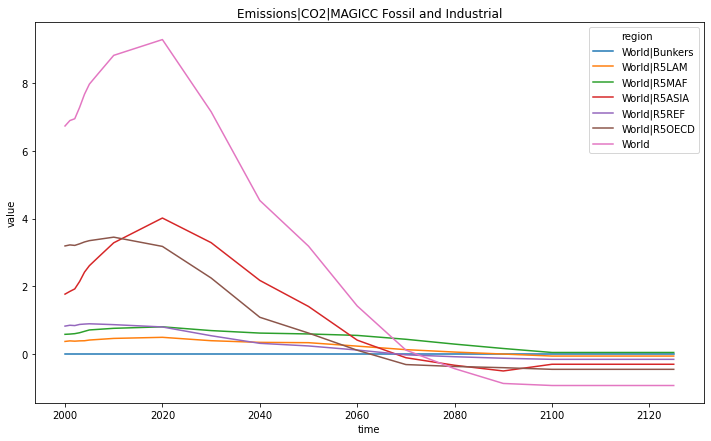

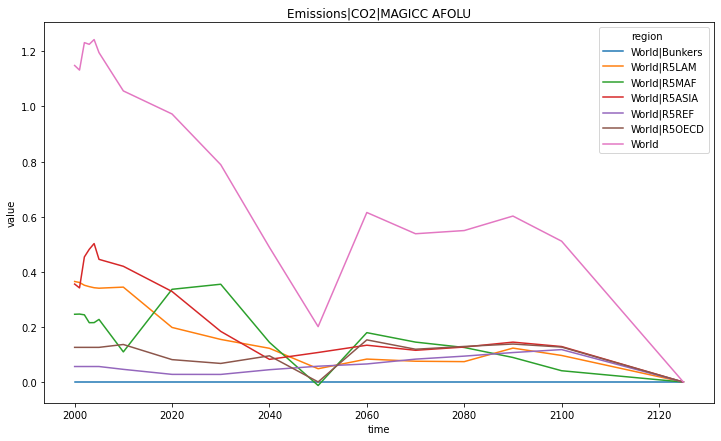

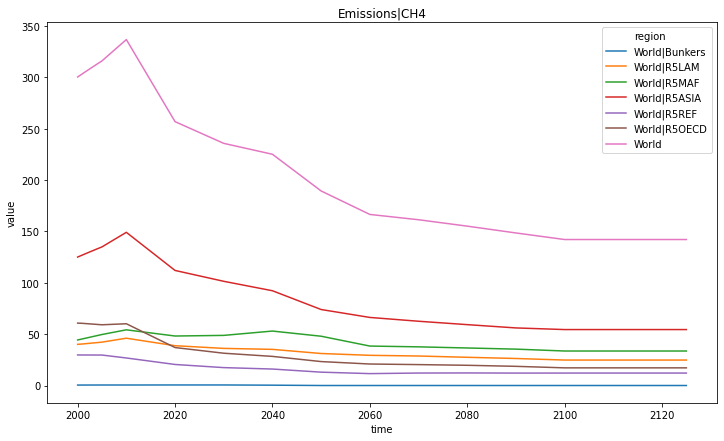

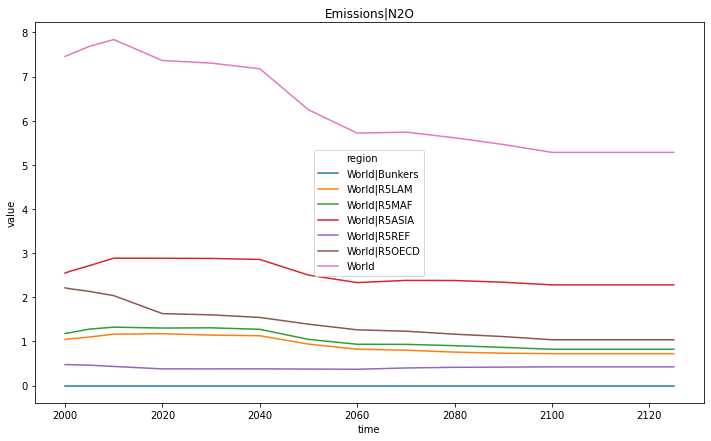

In [10]:
categories_to_plot = [
    "Emissions|" + v 
    for v in ["CO2|MAGICC Fossil and Industrial", "CO2|MAGICC AFOLU", "CH4", "N2O"]
]
for g in rcp26.filter(
    variable=categories_to_plot,
    year=range(1000, 2150)
).groupby("variable"):
    plt.figure(figsize=(12, 7))
    g.lineplot(hue="region").set_title(g.get_unique_meta("variable", True))

# Fossil fuel emissions for the four RCP scenarios.

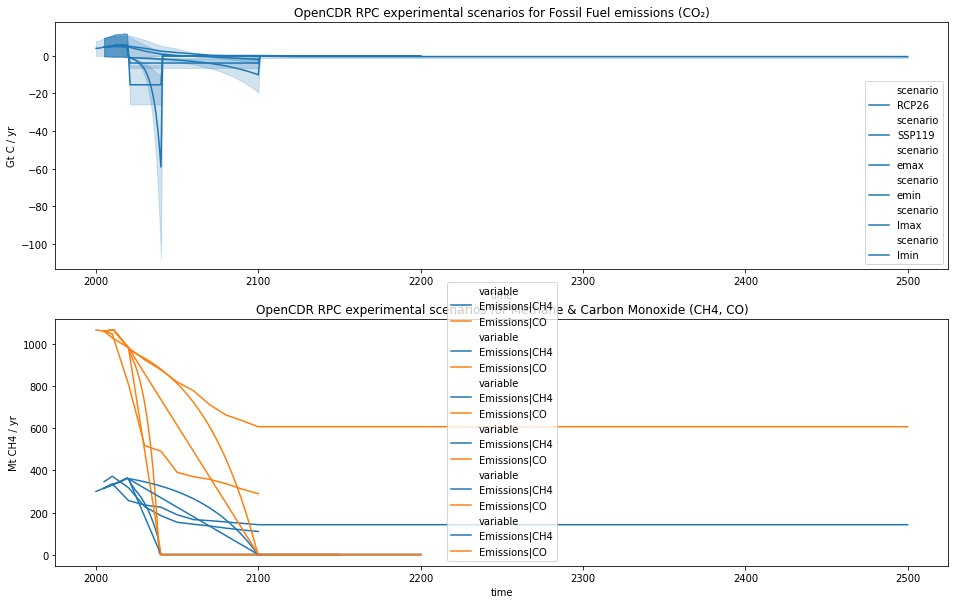

In [11]:
x="[datetime(2000, 1, 1), datetime(2500, 1, 1)]"
pret="OpenCDR RPC experimental scenarios for "
co2var = "*CO2|MAGICC Fossil and Industrial"
co2units = rcps.filter(variable = co2var)["unit"].iloc[0]

fig, (ax1,ax2) = plt.subplots(2,1, figsize = (16, 10))

for scen in rcps["scenario"].unique():
    rcps.filter(scenario = scen, variable = [co2var,"*CO2|MAGICC AFOLU"], 
                region = ["World"]).lineplot( hue = "scenario", ax = ax1)
    ax1.set_ylabel(co2units)
    ax1.set_title( pret + "Fossil Fuel emissions (CO₂)")

    rcps.filter(scenario = scen, variable = ["Emissions|CH4", "Emissions|CO"], 
                region = ["World"],).line_plot(hue = 'variable', ax = ax2);
    ax2.set_ylabel(rcps.filter(variable = "Emissions|CH4")["unit"].iloc[0])
    ax2.set_title( pret + "Methane & Carbon Monoxide (CH4, CO)")


## Running MAGICC

A single `pymagicc` run doesn't take long and returns a Pandas Dict.
(If not on Windows, the very first run might be slower due to setting up Wine.)

In [12]:
# NBVAL_IGNORE_OUTPUT
%time results = pymagicc.run(rcp26, **magcfg)
results = ""
%time results = pymagicc.run(rcps.filter(scenario="emin"), **magcfg)
results = ""
%time results = pymagicc.run(rcp26, **magcfg)
slice = results[["scenario","region","variable", "unit"]]
results = ""

/Users/shannon/workbench/pymagicc/venv/lib/python3.7/site-packages/scmdata/dataframe.py:1511: UserWarning: Duplicate time points detected, the output will be the average of the duplicates. Set `duplicate_msg='return'` to examine the joint timeseries (the duplicates can be found by looking at `res[res.index.duplicated(keep=False)].sort_index()`. Set `duplicate_msg=False` to silence this message.
  warnings.warn(warn_msg)


CPU times: user 4.72 s, sys: 567 ms, total: 5.29 s
Wall time: 12 s


/Users/shannon/workbench/pymagicc/venv/lib/python3.7/site-packages/scmdata/dataframe.py:1511: UserWarning: Duplicate time points detected, the output will be the average of the duplicates. Set `duplicate_msg='return'` to examine the joint timeseries (the duplicates can be found by looking at `res[res.index.duplicated(keep=False)].sort_index()`. Set `duplicate_msg=False` to silence this message.
  warnings.warn(warn_msg)


CPU times: user 3.82 s, sys: 517 ms, total: 4.34 s
Wall time: 10.4 s


/Users/shannon/workbench/pymagicc/venv/lib/python3.7/site-packages/scmdata/dataframe.py:1511: UserWarning: Duplicate time points detected, the output will be the average of the duplicates. Set `duplicate_msg='return'` to examine the joint timeseries (the duplicates can be found by looking at `res[res.index.duplicated(keep=False)].sort_index()`. Set `duplicate_msg=False` to silence this message.
  warnings.warn(warn_msg)


CPU times: user 3.8 s, sys: 552 ms, total: 4.35 s
Wall time: 10.4 s


/Users/shannon/workbench/pymagicc/venv/lib/python3.7/site-packages/scmdata/dataframe.py:1511: UserWarning: Duplicate time points detected, the output will be the average of the duplicates. Set `duplicate_msg='return'` to examine the joint timeseries (the duplicates can be found by looking at `res[res.index.duplicated(keep=False)].sort_index()`. Set `duplicate_msg=False` to silence this message.
  warnings.warn(warn_msg)
/Users/shannon/workbench/pymagicc/venv/lib/python3.7/site-packages/scmdata/dataframe.py:1511: UserWarning: Duplicate time points detected, the output will be the average of the duplicates. Set `duplicate_msg='return'` to examine the joint timeseries (the duplicates can be found by looking at `res[res.index.duplicated(keep=False)].sort_index()`. Set `duplicate_msg=False` to silence this message.
  warnings.warn(warn_msg)
/Users/shannon/workbench/pymagicc/venv/lib/python3.7/site-packages/scmdata/dataframe.py:1511: UserWarning: Duplicate time points detected, the output wi

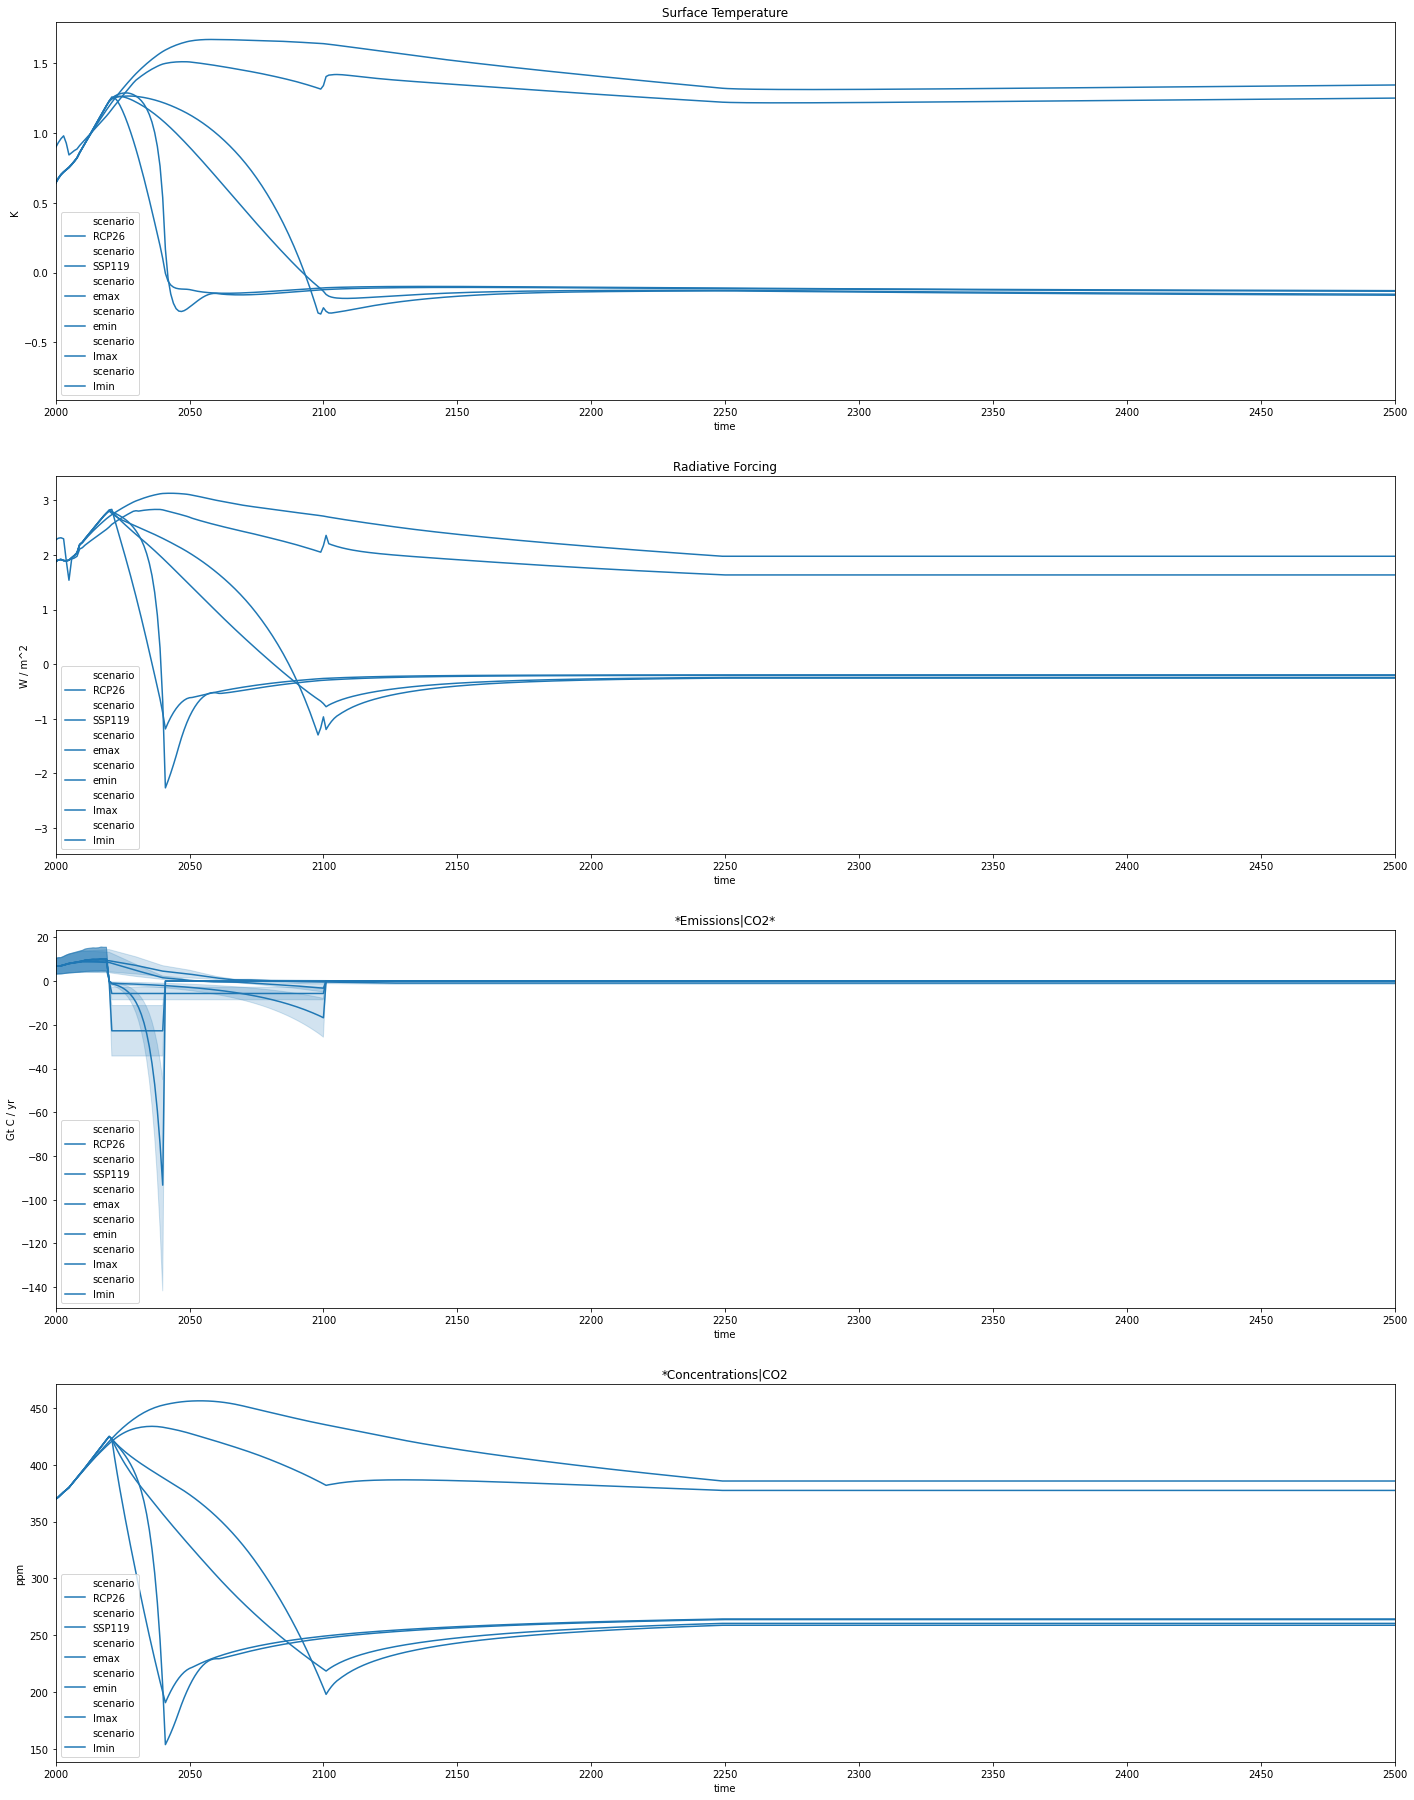

In [13]:
x=(datetime(2000, 1, 1), datetime(magcfg["endyear"], 1, 1))
fig, attr = plt.subplots(4, 1, figsize=(24, 32))
vars = ["Surface Temperature","Radiative Forcing","*Emissions|CO2*","*Concentrations|CO2"]

def populateplts (raw):
    for n, var in enumerate(vars):
        newax = attr[n]
        newax.set_title(var)
        newax.set_xlim(x)
        raw.filter(variable=var, 
               region="World").lineplot(hue="scenario", ax=newax);
        units = raw.filter(variable=var)["unit"].iloc[0]
        newax.set_ylabel(units)
    return(raw.filter)

with MAGICC6() as magicc:
    for sdf in rcps["scenario"].unique():
        raw = pymagicc.run(MAGICCData(rcps.filter(scenario=sdf).copy()), **magcfg)
        cntpltsA = populateplts(raw)
raw = ""

The default parameters are the ones that were used to produce the RCP GHG concentrations (see also http://live.magicc.org/). Of course it's easy to change them.

In [14]:
low = pymagicc.run(rcp45, core_climatesensitivity=1.5, endyear=magcfg["endyear"])
default = pymagicc.run(rcp45, core_climatesensitivity=3, endyear=magcfg["endyear"])
high = pymagicc.run(rcp45, core_climatesensitivity=4.5, endyear=magcfg["endyear"])

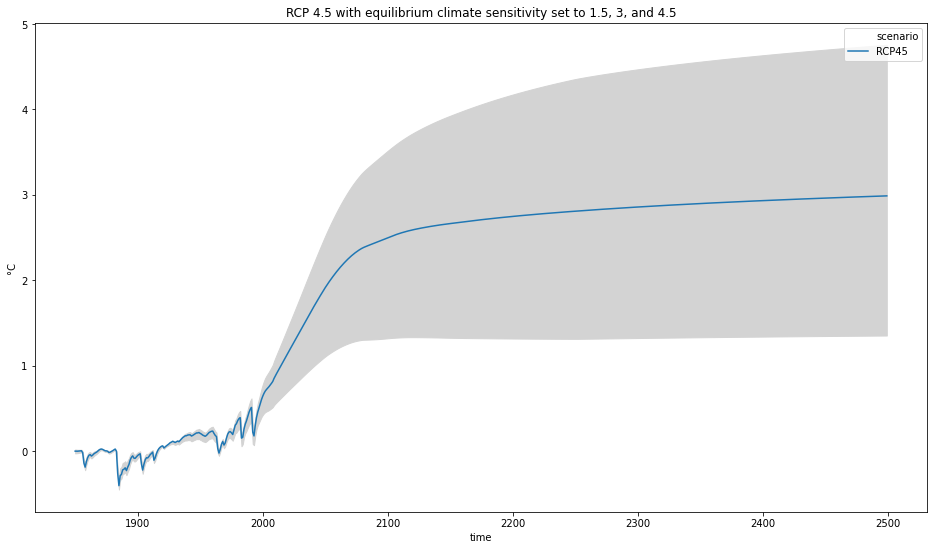

In [15]:
filtering = {
    "variable": "Surface Temperature",
    "region": "World",
    "year": range(1850, magcfg["endyear"]),
}

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
default.filter(**filtering).line_plot(x="time", ax=ax)
plt.fill_between(
    low.filter(**filtering)["time"].values,
    low.filter(**filtering).timeseries().values.squeeze(),
    high.filter(**filtering).timeseries().values.squeeze(),
    color="lightgray"
)

plt.title(
    "RCP 4.5 with equilibrium climate sensitivity set to 1.5, 3, and 4.5"
)
plt.ylabel("°C");